# 1. **Installation and imports**

In [ ]:
!pip install evaluate --quiet
!pip install captum --quiet
!pip install seaborn --quiet

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import evaluate
import warnings
warnings.filterwarnings('ignore')

from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients, configure_interpretable_embedding_layer

from transformers import BertTokenizer, BertForSequenceClassification #, BertConfig, EvalPrediction, InputFeatures, Trainer, TrainingArguments, glue_compute_metrics
from src.config import load_config
from src.model import PatentSentenceClassifier

# **2. Loading the model**

In [7]:
# Load Config
cfg = load_config('/workspace/config.yaml')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# load Tokenizer and Base Model
bert_tokenizer = BertTokenizer.from_pretrained(cfg.model.name)
base_model = BertForSequenceClassification.from_pretrained(cfg.model.name, num_labels=cfg.model.num_lables, output_attentions=True)
base_model.to(device)
base_model.eval()
base_model.zero_grad()
print('\nTokenizer and Base Model loaded succesfully.')

# Load Finetuned Patent Model
checkpoint_path = '/workspace/models/finetuning/bert-for-patents_train_10_7.ckpt'
loaded_model = PatentSentenceClassifier.load_from_checkpoint(checkpoint_path, model=base_model, tokenizer=bert_tokenizer)
loaded_model.eval()
loaded_model.to(device)
loaded_model.zero_grad()
print('\nModel loaded succesfully.')

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenizer and Base Model loaded succesfully.

Model loaded succesfully.


# **3. Interpretability with Layer Integrated Gradients**

In [8]:
# Select Sentence
text = "Additionally, the stopper 108 is used at the distal end of the wire where the loop is formed to substantially secure the loop closed." # MIX
text = "Provisional Patent Application number 62/571,193; filed Oct. 11, 2017; and entitled INSECT VACUUM AND TRAP ATTACHMENT SYSTEMS." #OTH
text = "In some embodiments, the horizontal position of the idler support block 1213 may be adjustable to maintain tension on the chain 1212." #FUN
text = "The rigid foam layer 50 is typically selected from the group of polyurethane foams, polyurea foams, and combinations thereof." # STR
text = "If there are no allocated cells to a hub using the previous criterion, the first allocated cell will be the closest cell to that hub." #FUN

text= "the motor is activated by a pressure sensor which includes several components."
true_label = 0 # int_to_label = {0: 'FUN', 1: 'STR', 2: 'MIX', 3: 'OTH'}

In [9]:
def predict_forward_func(input_ids, token_type_ids=None, position_ids=None, attention_mask=None):
    return loaded_model(input_ids=input_ids, 
                 token_type_ids=token_type_ids, 
                 position_ids=position_ids, 
                 attention_mask=attention_mask)[0]

def predict(input_ids, token_type_ids=None, position_ids=None, attention_mask=None, model=loaded_model):
    """A helper function to perform forward pass of the model and make predictions"""
    output = model(input_ids=input_ids, 
                   token_type_ids=token_type_ids,
                   position_ids=position_ids, 
                   attention_mask=attention_mask)
    return output  

def prepare_input(text, tokenizer):
    """Prepare ig attribution input: tokenize sample and baseline text."""
    tokenized_text = tokenizer(text, return_tensors="pt", return_attention_mask=True)
    seq_len = tokenized_text["input_ids"].shape[1]
    position_ids = torch.arange(seq_len, dtype=torch.long).unsqueeze(0)
    
    # Construct the baseline.
    # A sequence of [PAD] tokens of length equal to that of the processed sample
    ref_text = tokenizer.pad_token * (seq_len - 2) # special tokens
    tokenized_ref_text = tokenizer(ref_text, return_tensors="pt") 
    ref_position_ids = torch.arange(seq_len, dtype=torch.long).unsqueeze(0)

    return (tokenized_text["input_ids"],              # 0
            tokenized_text["token_type_ids"],         # 1
            position_ids,                             # 2
            tokenized_ref_text["input_ids"],          # 3
            tokenized_ref_text["token_type_ids"],     # 4
            ref_position_ids,                         # 5
            tokenized_text["attention_mask"])         # 6

def place_on_device(*tensors):
    tensors_device = []
    for t in tensors:
        tensors_device.append(t.to(device))
    return tuple(tensors_device)  

def lig_attribute(lig, class_index, input_data):
    return lig.attribute(
        inputs=input_data[0],
        baselines=input_data[3],
        additional_forward_args=(input_data[1], input_data[2], input_data[6]),
        return_convergence_delta=True,
        target=class_index,
        n_steps=200
    )

In [10]:
# Input for lig attributions
input_data = place_on_device(*prepare_input(text, tokenizer=bert_tokenizer))

In [11]:
# 1. Layer: model.bert.embeddings.word_embeddings
# base_model.bert.embeddings.word_embeddings
# loaded_model.model.bert.embeddings.word_embeddings
lig_we = LayerIntegratedGradients(predict_forward_func, loaded_model.model.bert.embeddings.word_embeddings)

attr_0, delta_0 = lig_attribute(lig = lig_we, class_index= 0, input_data=input_data)
attr_1, delta_1 = lig_attribute(lig = lig_we, class_index= 1, input_data=input_data)
attr_2, delta_2 = lig_attribute(lig = lig_we, class_index= 2, input_data=input_data)
attr_3, delta_3 = lig_attribute(lig = lig_we, class_index= 3, input_data=input_data)

print("Shape of attributions:")
print(attr_0.shape, attr_1.shape, attr_2.shape, attr_3.shape)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Shape of attributions:
torch.Size([1, 15, 1024]) torch.Size([1, 15, 1024]) torch.Size([1, 15, 1024]) torch.Size([1, 15, 1024])


In [12]:
# Vizualization
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions


def get_visualization_record(text, attributions_sum, scores, true_label, all_tokens, approximation_error):
    return viz.VisualizationDataRecord(
        attributions_sum,
        torch.max(torch.softmax(scores[0], dim=0)),
        torch.argmax(scores),
        true_label,
        text,
        attributions_sum.sum(),
        all_tokens,
        approximation_error)
    
def visualize_attributions(text, true_label, input_data, attr_0, delta_0, attr_1, delta_1, tokenizer=bert_tokenizer):       
    # Run inference
    preds = predict(*input_data[0:3], input_data[-1])
    scores = preds.logits
    output_attentions = preds.attentions
    # shape -> layer x batch x head x seq_len x seq_len
    output_attentions_all = torch.stack(output_attentions)

    # Prepare visualization 
    indices = input_data[0][0].detach().tolist()
    all_tokens = tokenizer.convert_ids_to_tokens(indices)
    attr_0_sum = summarize_attributions(attr_0)
    attr_1_sum = summarize_attributions(attr_1)
    attr_2_sum = summarize_attributions(attr_2)
    attr_3_sum = summarize_attributions(attr_3)

    data_vis_0 = get_visualization_record(text, attr_0_sum, scores, true_label, all_tokens, delta_0)  
    data_vis_1 = get_visualization_record(text, attr_1_sum, scores, true_label, all_tokens, delta_1)
    data_vis_2 = get_visualization_record(text, attr_2_sum, scores, true_label, all_tokens, delta_2)
    data_vis_3 = get_visualization_record(text, attr_3_sum, scores, true_label, all_tokens, delta_3)

    # Visualize
    print("\nClass index: 0 (FUN)")
    viz.visualize_text([data_vis_0])
    print("Class index: 1 (STR)")
    viz.visualize_text([data_vis_1])
    print("Class index: 1 (MIX)")
    viz.visualize_text([data_vis_1])
    print("Class index: 1 (OTH)")
    viz.visualize_text([data_vis_1])

    return output_attentions_all, all_tokens, attr_0_sum, attr_1_sum, attr_2_sum, attr_3_sum

In [13]:
output_attentions_all, all_tokens, attr_0_sum, attr_1_sum, attr_2_sum, attr_3_sum = visualize_attributions(text, true_label, input_data, attr_0, delta_0, attr_1, delta_1)


Class index: 0 (FUN)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.83),the motor is activated by a pressure sensor which includes several components.,3.37,[CLS] the motor is activated by a pressure sensor which includes several components . [SEP]


Class index: 1 (STR)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.83),the motor is activated by a pressure sensor which includes several components.,-3.41,[CLS] the motor is activated by a pressure sensor which includes several components . [SEP]


Class index: 1 (MIX)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.83),the motor is activated by a pressure sensor which includes several components.,-3.41,[CLS] the motor is activated by a pressure sensor which includes several components . [SEP]


Class index: 1 (OTH)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.83),the motor is activated by a pressure sensor which includes several components.,-3.41,[CLS] the motor is activated by a pressure sensor which includes several components . [SEP]


# **4. Visualizing Attention Matrices**

*   `visualize_token2token_scores`: visualization of token-to-token attention scores for all heads; 
*   `visualize_avg_attention_per_token`: visualization of the average attention for each individual token.

In [14]:
def visualize_token2token_scores(scores_mat, all_tokens):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 4, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format("Head", idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

def visualize_avg_attention_per_token(scores_mat, all_tokens):
    # Compute average attention (across heads and attended tokens)
    avg_heads = scores_mat.mean(axis=0)
    avg_tokens = avg_heads.mean(axis=0)

    # Removing special tokens
    avg_tokens = avg_tokens[1:-2]
    all_tokens = all_tokens[1:-2]
    print("Average attention scores (without special tokens)")
    plt.figure(figsize=(12,6))
    plt.bar(all_tokens, avg_tokens)
    plt.xticks(rotation=90, fontsize=15)
    plt.show()

In [15]:
# Run inference
preds = predict(*input_data[0:3], attention_mask = input_data[6], model=loaded_model)
scores = preds.logits
output_attentions = preds.attentions
# shape -> layer x batch x head x seq_len x seq_len
output_attentions_all = torch.stack(output_attentions)
print(f"Attentions shape: {output_attentions_all.shape}")

# Prepare visualization 
indices = input_data[0][0].detach().tolist()
all_tokens = bert_tokenizer.convert_ids_to_tokens(indices)
print(f"\nAll tokens: {all_tokens}")

Attentions shape: torch.Size([24, 1, 16, 15, 15])

All tokens: ['[CLS]', 'the', 'motor', 'is', 'activated', 'by', 'a', 'pressure', 'sensor', 'which', 'includes', 'several', 'components', '.', '[SEP]']


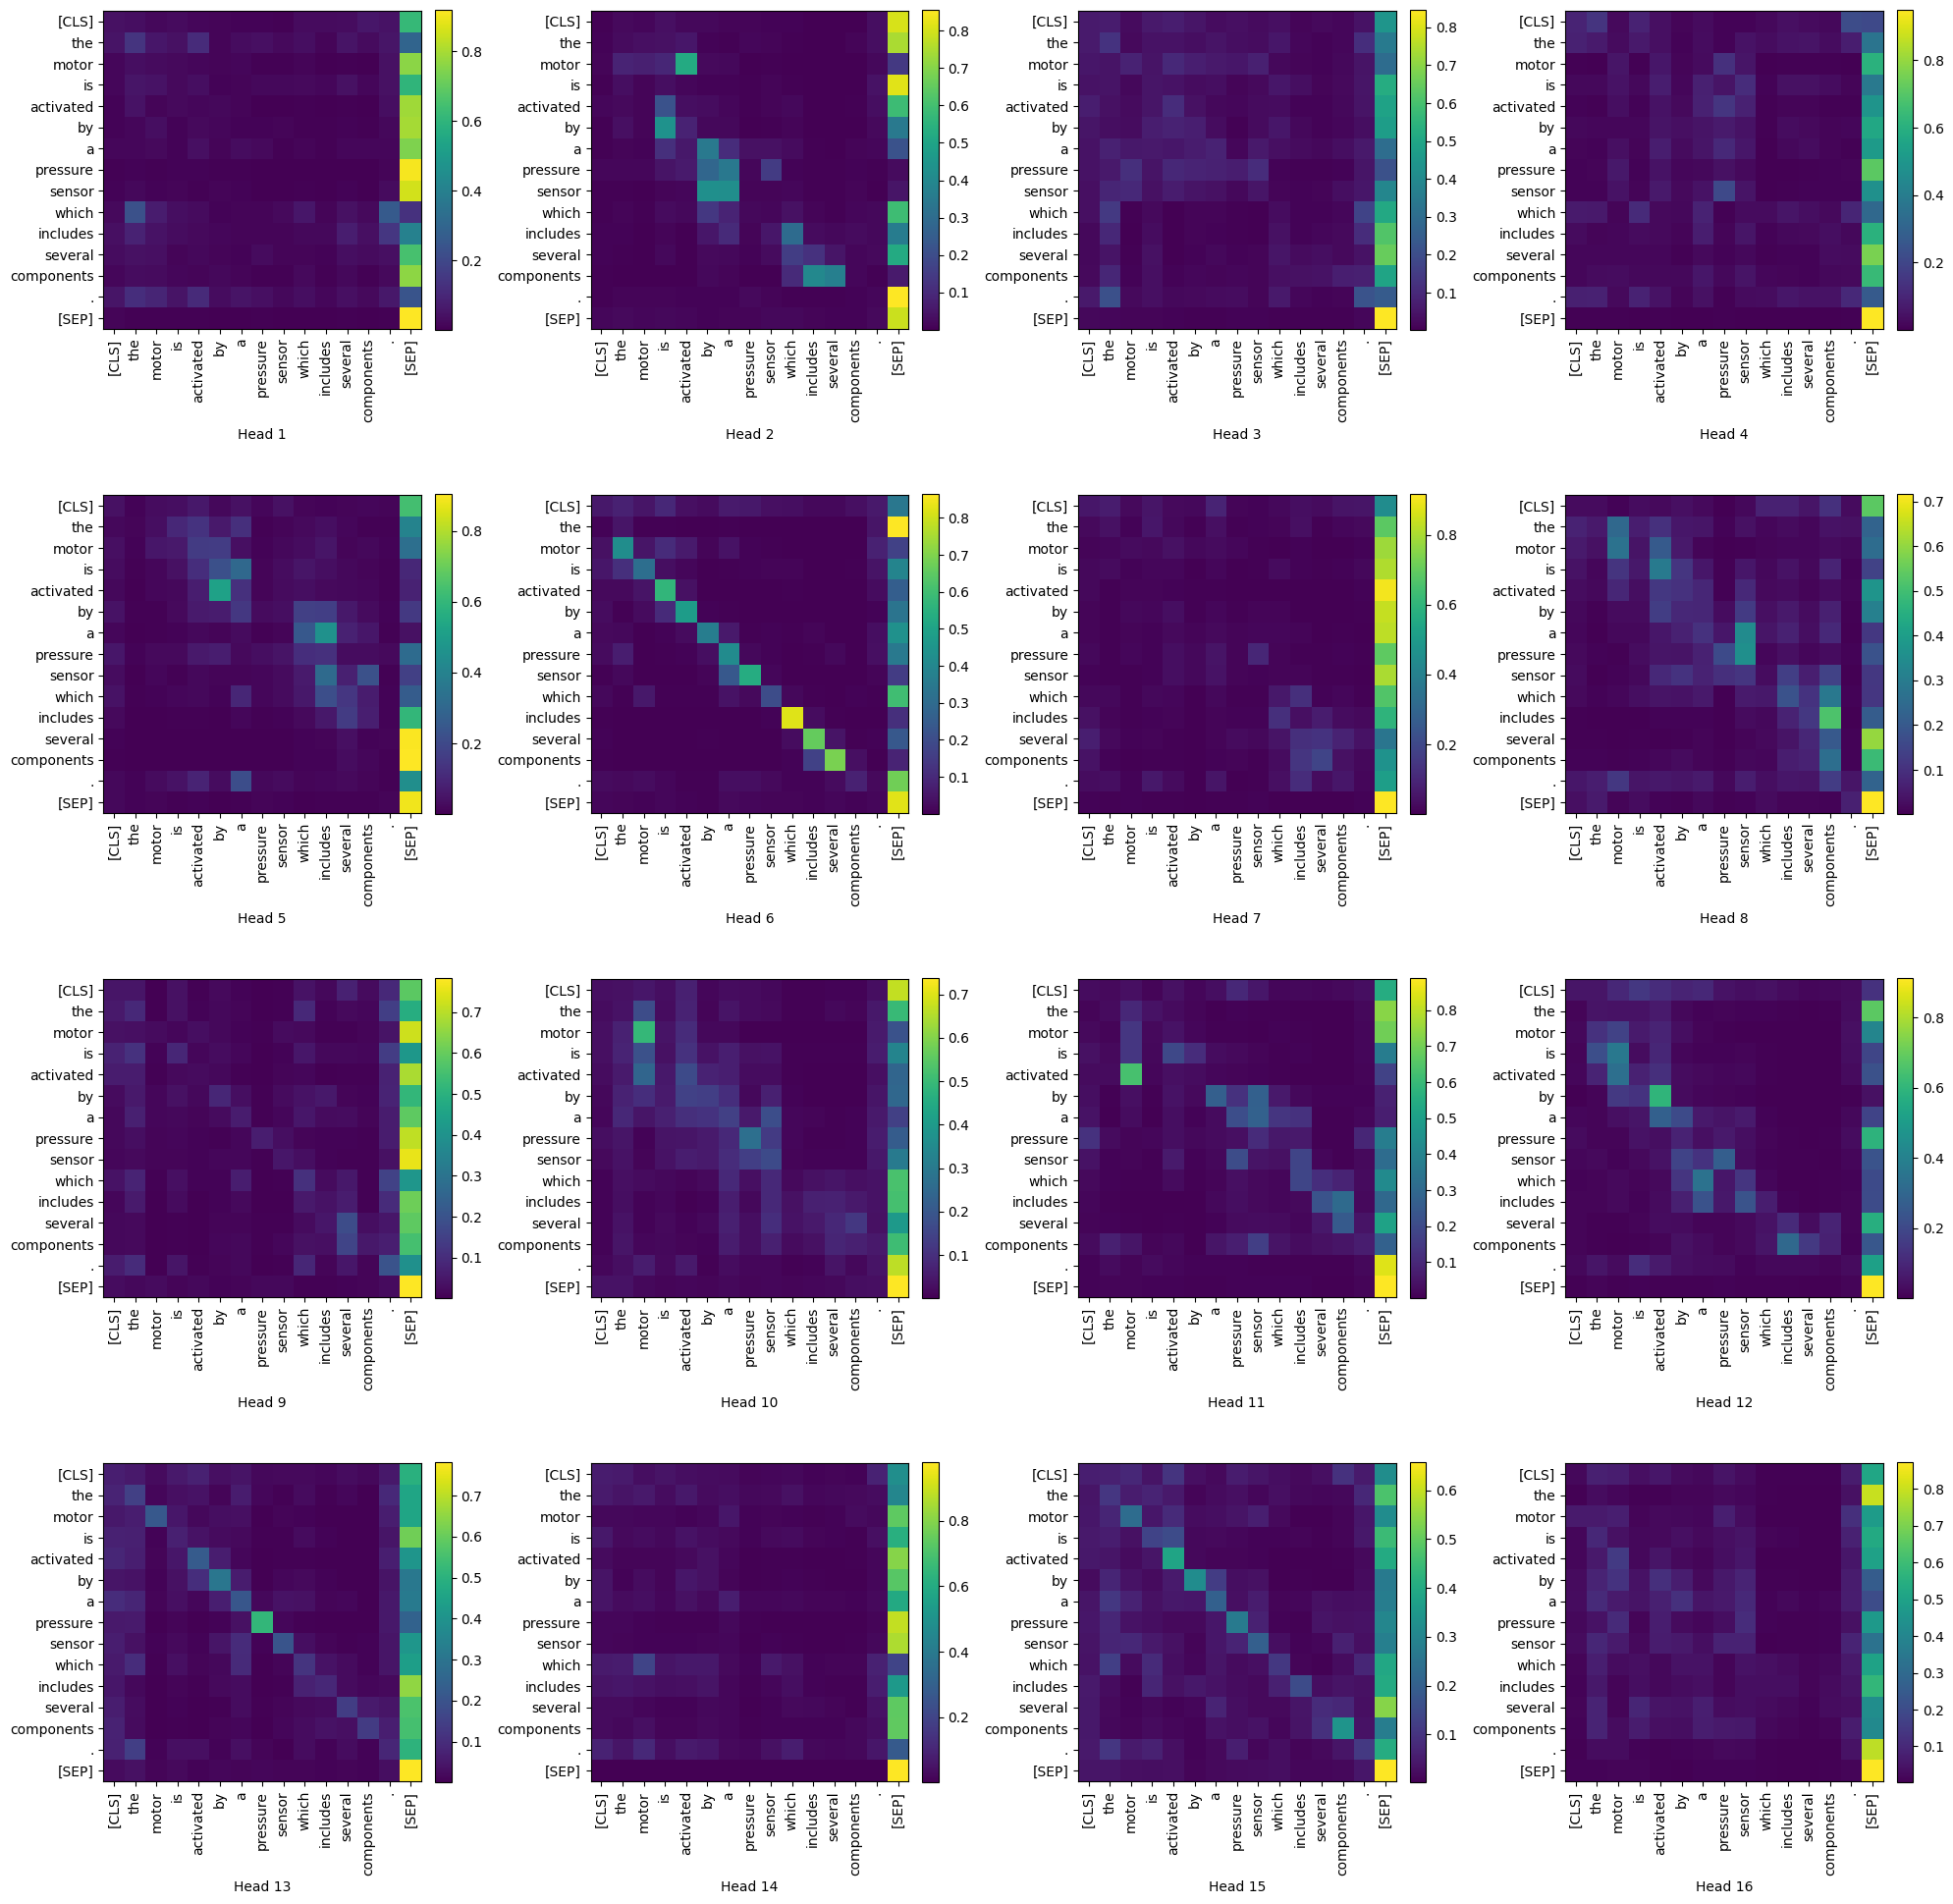

In [16]:
layer = 14 # 0 is the index of first layer (i.e. the layer more close to the input sequence)
visualize_token2token_scores(output_attentions_all[layer].squeeze().detach().cpu().numpy(), all_tokens)

Average attention scores (without special tokens)


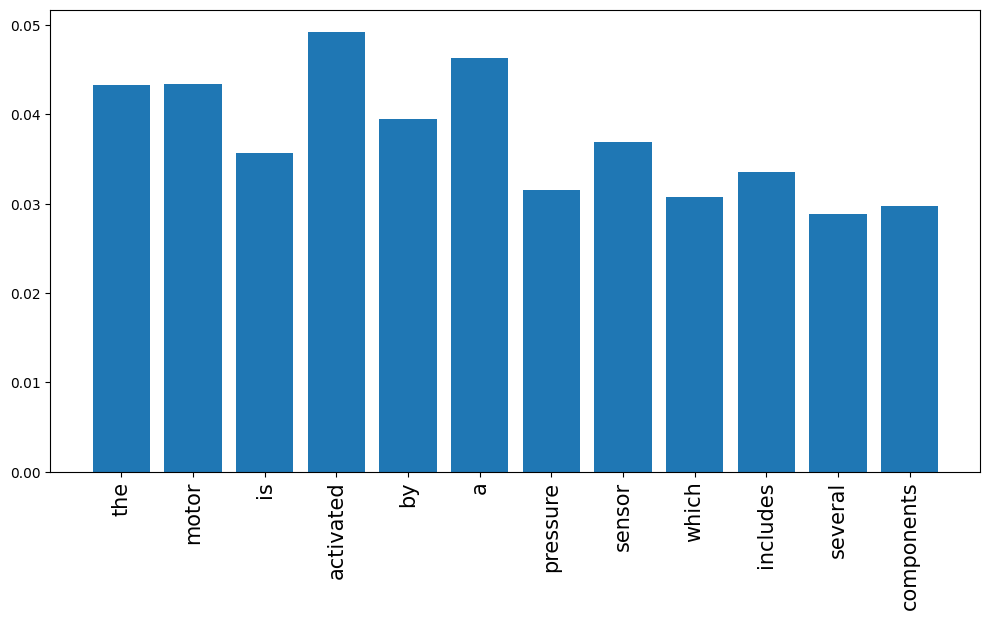

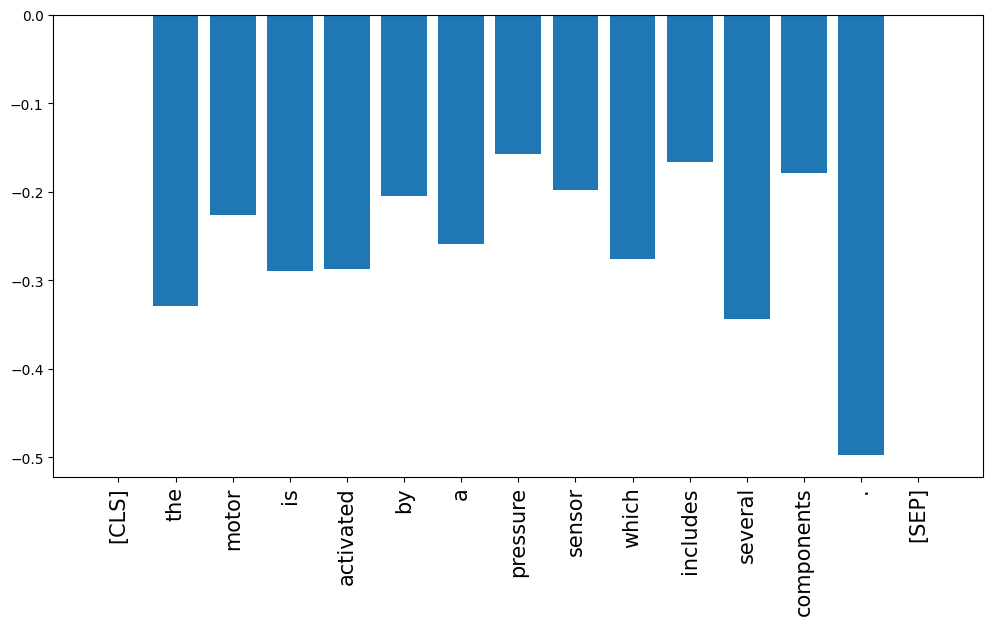

In [17]:
visualize_avg_attention_per_token(output_attentions_all[layer].squeeze().detach().cpu().numpy(), all_tokens)

# Comparison with IG method (attribution scores computed with target class equal to 1)
plt.figure(figsize=(12,6))
plt.bar(all_tokens, attr_1_sum.cpu()) #.cpu()
plt.xticks(rotation=90, fontsize=15)
plt.show()